In [1]:
import numpy as np
import pandas as pd
import os
import time
from gensim.parsing.preprocessing import remove_stopwords
from gensim import models
from pathlib import Path
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from string import digits

2022-06-21 18:01:03.634541: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# loading datasets and preliminary cleaning

subtitles=pd.read_csv('../../data/movies_subtitles.csv')
metas=pd.read_csv('../../data/movies_meta.csv')
metas=metas.loc[metas['original_language']=='en']  # only english movies
metas=metas.drop(['production_countries', 'overview', 'tagline', 'belongs_to_collection', 'homepage', 'revenue', 'spoken_languages', 'video', 'homepage', "poster_path", 'production_companies'], axis=1)


indexes=list(metas['imdb_id'])
subtitles=subtitles.loc[subtitles['imdb_id'].isin(indexes)] # remove all movies that are not in metas dataset
print("{} subtitles from {} movies".format(len(subtitles), len(metas)))

5589021 subtitles from 3608 movies


In [3]:
# load NLU model

model = GPT2LMHeadModel.from_pretrained('gpt2')  
word_embeddings = model.transformer.wte.weight  
position_embeddings = model.transformer.wpe.weight 
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [4]:
# clean subtitle's text

def clean_text(x):
    '''
    method to normalize the movie titles
    '''
    x=x.lower()    
    for char in ["\n", "-"]: #["-", ",", ".", ":", ";", "(", ")", "/", "!", "?", "%", "<i>", "<u>",  "<b>", "♪", " s ", " m ", " t ", " ve ", "#"]:
        x=x.replace(char, " ") 
    if "♪" in x:
        x=""
   # x=remove_stopwords(x)
    return x
 
subtitles=subtitles.dropna()
subtitles['text']=subtitles['text'].apply(clean_text)

In [5]:

movies_list=[]

for index in subtitles['imdb_id'].unique()[:10]:
    globals()['%s' % index]= subtitles.loc[subtitles['imdb_id']==index]
    movies_list.append(globals()['%s' % index])

In [6]:
#create dictionary {movie_id:subtitles}

subtitles_str={}

for movie in movies_list:
    movie=movie.reset_index()
    imdb_id=movie['imdb_id'][0]
    sub=""
    for i in movie['text']:
        sub+=i
    char="\'"
    subtitles_str[imdb_id]=sub.replace(char, "")  

In [7]:
print(subtitles_str.keys())

dict_keys(['tt0114709', 'tt0113497', 'tt0113189', 'tt0113627', 'tt0112637', 'tt0112818', 'tt0113442', 'tt0112697', 'tt0113855', 'tt0114148'])


In [8]:
# create dataframe with subtitles of every movie

movies_ids=list(subtitles['imdb_id'].unique())
movies_list=[]

for index in movies_ids[:5]:
    globals()['%s' % index]= subtitles.loc[subtitles['imdb_id']==index]
    movies_list.append(globals()['%s' % index])

In [9]:
# creating the matrix for every movie

remove_digits = str.maketrans('', '', digits) # object to remove numbers

matrix_subtitles=[]#pd.DataFrame(movies_list, columns=["movie"])

for movie in movies_list[:5]:
        
    dimension=int(len(movie)/768)
    low_bound=0
    high_bound=dimension   
 
    movie_words=[]
    
    # for every split of one movie's subtitle get list of words
    for i in range(768):
        text=[]
        subset=movie.iloc[low_bound:high_bound]       
        text+=subset['text'].to_string().split() # split string
        text = [x for x in text if not (x.isdigit())]  # remove numbers (index)
        globals()['sentences_%s' % i]=text
        low_bound+=dimension
        high_bound+=dimension
        movie_words.append(globals()['sentences_%s' % i])  # append list of words to movie_words
        
        
################ split for time complexity????
    matrix=[]

    # for every list of words obtain vector and append to matrix
    for sentence in movie_words:
        sent_vect=[]
        for word in sentence:
            text_index = tokenizer.encode(word,add_prefix_space=True)
            vector = model.transformer.wte.weight[text_index,:]
            vector=vector.detach().numpy()         
            sent_vect.append(vector[0])
        matrix.append(np.sum(sent_vect, axis=0) / len(sent_vect))  
   
    matrix_subtitles.append(np.array(matrix))
    

        

/tmp/ipykernel_449/1930070924.py:38: RuntimeWarning: invalid value encountered in double_scalars
  matrix.append(np.sum(sent_vect, axis=0) / len(sent_vect))
/tmp/ipykernel_449/1930070924.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  matrix_subtitles.append(np.array(matrix))


In [10]:
print(len(matrix_subtitles))
print(type(matrix_subtitles))
print(type(matrix_subtitles[0]))

5
<class 'list'>
<class 'numpy.ndarray'>


TypeError: Image data of dtype object cannot be converted to float

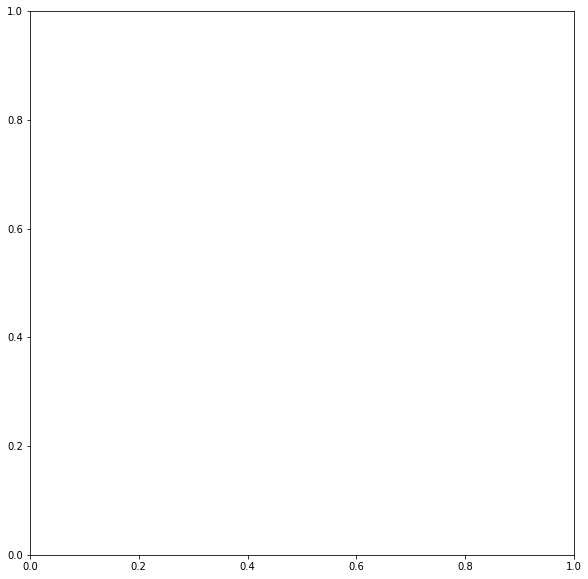

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(matrix_subtitles[0], cmap='hot', interpolation='nearest')
plt.show()

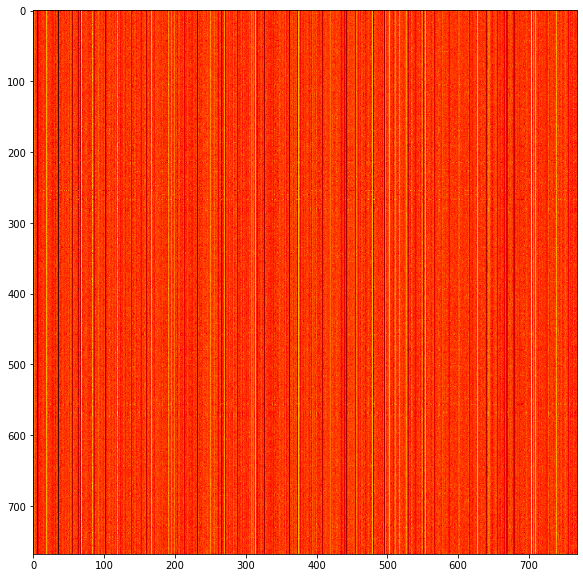

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(matrix_subtitles[3], cmap='hot', interpolation='nearest')
plt.show()

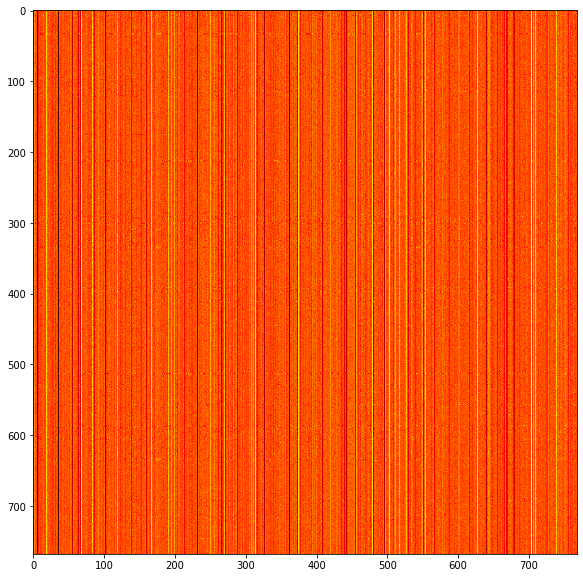

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(matrix_subtitles[4], cmap='hot', interpolation='nearest')
plt.show()

In [14]:
print(len(movies_list[0][0]))

KeyError: 0